# Crack detection in concrete

## Importing necessary libraries

In [35]:
import pandas as pd
import os
import random
import cv2
from matplotlib import pyplot as plt
import splitfolders
import numpy as np
from torchsummary import summary

## Loading the dataset

In [2]:
positive_dataset_path = './Concrete Crack Images for Classification/Positive/'
negative_dataset_path = './Concrete Crack Images for Classification/Negative/'
dataset_path = "Concrete Crack Images for Classification"

In [3]:
pos_images = os.listdir(positive_dataset_path)
neg_images = os.listdir(negative_dataset_path)

Number of images with cracks: 20000
Number of images without crack: 20000
Image with a crack


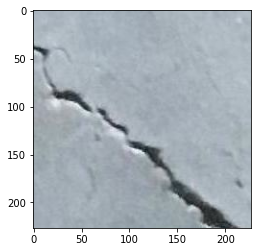

Image without a crack


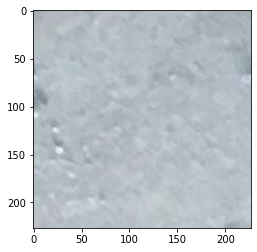

In [4]:
print('Number of images with cracks:', len(pos_images))
print('Number of images without crack:', len(neg_images))
pos_path = pos_images[random.randint(0,len(pos_images))]
rand_pos_img = cv2.imread(f'{positive_dataset_path}{pos_path}')
neg_path = neg_images[random.randint(0,len(neg_images))]
rand_neg_img = cv2.imread(f'{negative_dataset_path}{neg_path}')
print("Image with a crack")
plt.imshow(rand_pos_img)
plt.show()
print("Image without a crack")
plt.imshow(rand_neg_img)
plt.show()

### Divide into train, test and validation

In [5]:
root_dir = 'Images'
pos_dir = 'Positive'
neg_dir = 'Negative'

In [6]:
def split_data():
    splitfolders.ratio(input=dataset_path, output=root_dir, seed=1337, ratio=(.7, .15, .15), group_prefix=None )
# split_data()

In [7]:
train_pos = os.listdir(f'{root_dir}/train/{pos_dir}')
train_neg = os.listdir(f'{root_dir}/train/{neg_dir}')
val_pos = os.listdir(f'{root_dir}/val/{pos_dir}')
val_neg = os.listdir(f'{root_dir}/val/{neg_dir}')
test_pos = os.listdir(f'{root_dir}/test/{pos_dir}')
test_neg = os.listdir(f'{root_dir}/test/{neg_dir}')


In [8]:
print("Number of train positive: ", len(train_pos))
print("Number of train neg: ", len(train_neg))
print("Number of val positive: ", len(val_pos))
print("Number of val neg: ", len(val_neg))
print("Number of test positive: ", len(test_pos))
print("Number of test neg: ", len(test_neg))

Number of train positive:  14000
Number of train neg:  14000
Number of val positive:  3000
Number of val neg:  3000
Number of test positive:  3000
Number of test neg:  3000


## Dataloader and transform

In [9]:
import timm
import torch
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [10]:
data_transformer = {'train': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
]), 'val': ([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])}

/usr/local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [11]:
def dataloader(mode):
    path = os.path.join(root_dir, mode)
    transformer = None if mode == "test" else data_transformer[mode]
    dataset = datasets.ImageFolder(
        root = path,
        transform = transformer
    )
    # Can have batchsize in dataloader
    data_loader = DataLoader(
        dataset,
        batch_size=8,
        shuffle =True
    )
    return data_loader, dataset

In [12]:
dataloder_train, dataset_train = dataloader("train")

In [27]:
print(f"Length of dataset: {len(dataset_train)}, classes in dataset: {dataset_train.classes}")
inputs, classes = next(iter(dataloder_train))
print("Shape of image:", inputs.shape)

Length of dataset: 28000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([8, 3, 224, 224])


In [28]:
print(classes[0])

tensor(1)


### Function for visualizing images

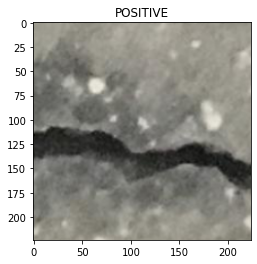

In [29]:
def show_img(img_arr, classname=None):
    img = np.transpose(img_arr.numpy(), (1, 2, 0))
    mean = np.array(IMAGENET_DEFAULT_MEAN)
    std = np.array(IMAGENET_DEFAULT_STD)
    img = img*std+mean
    plt.imshow(img)
    if classname!=None:
        title = "POSITIVE" if classname==1 else "NEGATIVE"
        plt.title(title)

show_img(inputs[0], classes[0])

## Create model

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [32]:
resnet50 = models.resnet50(pretrained=True)
if torch.cuda.is_available():
    print("Cuda is available")
    resnet50.to('cuda')



In [36]:
summary(resnet50, inputs[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,